In [1]:
import numpy as np
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from pytolemaic import PyTrust, FeatureTypes, Metrics, DMD

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import time
import math
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# load data
dataset = pl.read_parquet("../data/clean/dataset.parquet").to_pandas()
dataset.shape

(8585, 290)

In [3]:
# declare base parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 32,
    'min_gain_to_split': 0,
    'feature_fraction_bynode': 1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'cat_l2': 10,
    'cat_smooth': 10,
    'verbosity': -1,
    'seed': 0
}

In [4]:
# update with tuned params from analysis.ipynb
params.update({'feature_fraction': 0.7274049492997424, 'cat_l2': 7.338696749456784, 'cat_smooth': 9.793892656173774})
params.update({'num_iterations': 2269})

In [5]:
# create list of numerical / categorical features
num, cat = FeatureTypes.numerical, FeatureTypes.categorical
feature_types = []

for cn in dataset.columns:
    if dataset[cn].dtype.name == 'category':
        feature_types.append(cat)
    else: 
        feature_types.append(num)

In [6]:
# create data object for pytolemaic
dmd_train, dmd_test = DMD.from_df(
    df_train=dataset, 
    df_test=None,
    is_classification=False,
    target_name='target',
    feature_types=feature_types,
    categorical_encoding=True,
    split_ratio=0.2
)

[2023-05-02 16:29:16][pytolemaic.utils.dmd][INFO]: Creating DMDs
[2023-05-02 16:29:16][pytolemaic.utils.dmd][INFO]: Categorical Encoding
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #0:'data_year'. Feature type is 'numerical'
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #1:'child_date'. Feature type is 'numerical'
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #2:'child_age'. Feature type is 'numerical'
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #3:'child_enrolment_date'. Feature type is 'numerical'
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #4:'child_months_enrolment'. Feature type is 'numerical'
[2023-05-02 16:29:17][pytolemaic.utils.label_encoder_wrapper][INFO]: Fit encoding for feature #5:'child_grant'. Feature type is 'categorical'
[2023-

In [7]:
# dataset for lightgbm
lgb_train = lgb.Dataset(data=dmd_train.values, label=dmd_train.target)

# fit model
bst = lgb.train(
    params=params,
    train_set=lgb_train,
)

In [8]:
# create object for feature sensitivity
pytrust = PyTrust(
    model=bst,
    xtrain=dmd_train,
    xtest=dmd_test,
    metric=Metrics.rmse
)

In [9]:
# feature sensitivity report
sensitivity_report = pytrust.sensitivity_report

print("\n".join(sensitivity_report.insights()))

SensitivityOfFeaturesReport.shuffled: More than 144 of features have low sensitivity
SensitivityOfFeaturesReport.shuffled: The most important feature is 'child_observe_score', followed by 'child_age'and 'teacher_emotional_total'.
SensitivityOfFeaturesReport.shuffled: The following features has 0 sensitivity:
	'pri_mobile', 'pri_days', 'pri_language_9', 'pri_language_10', 'pri_language_97', 'pri_toys', 'pri_funding_97', 'pri_meals', 'obs_materials_97', 'obs_materials_0', 'obs_potable', 'obs_handwashing_0', 'obs_toilet_8', 'obs_toilet_0', 'obs_toilet_97', 'count_register_gender_other', 'count_register_year_2013', 'count_register_race_other', 'count_staff_gender_other', 'pre_covid'
SensitivityOfFeaturesReport.missing: More than 144 of features have low sensitivity
SensitivityOfFeaturesReport.missing: The most important feature is 'child_observe_score', followed by 'child_age'and 'child_observe_attentive_ordinal'.
SensitivityOfFeaturesReport.missing: The following features has 0 sensitivit

In [10]:
# report which features the model is most sensitive too
sensitivity_report.shuffle_report.sorted_sensitivities[:15]

[('child_observe_score', 0.08203),
 ('child_age', 0.07814),
 ('teacher_emotional_total', 0.04667),
 ('id_enumerator', 0.04243),
 ('child_height', 0.03186),
 ('child_date', 0.0305),
 ('child_observe_diligent_ordinal', 0.0279),
 ('child_observe_attentive_ordinal', 0.02363),
 ('child_observe_total', 0.02322),
 ('latitude', 0.01766),
 ('pri_fees_amount', 0.01645),
 ('child_age_group', 0.01474),
 ('child_gender', 0.01377),
 ('child_zha', 0.01311),
 ('id_ward', 0.01307)]

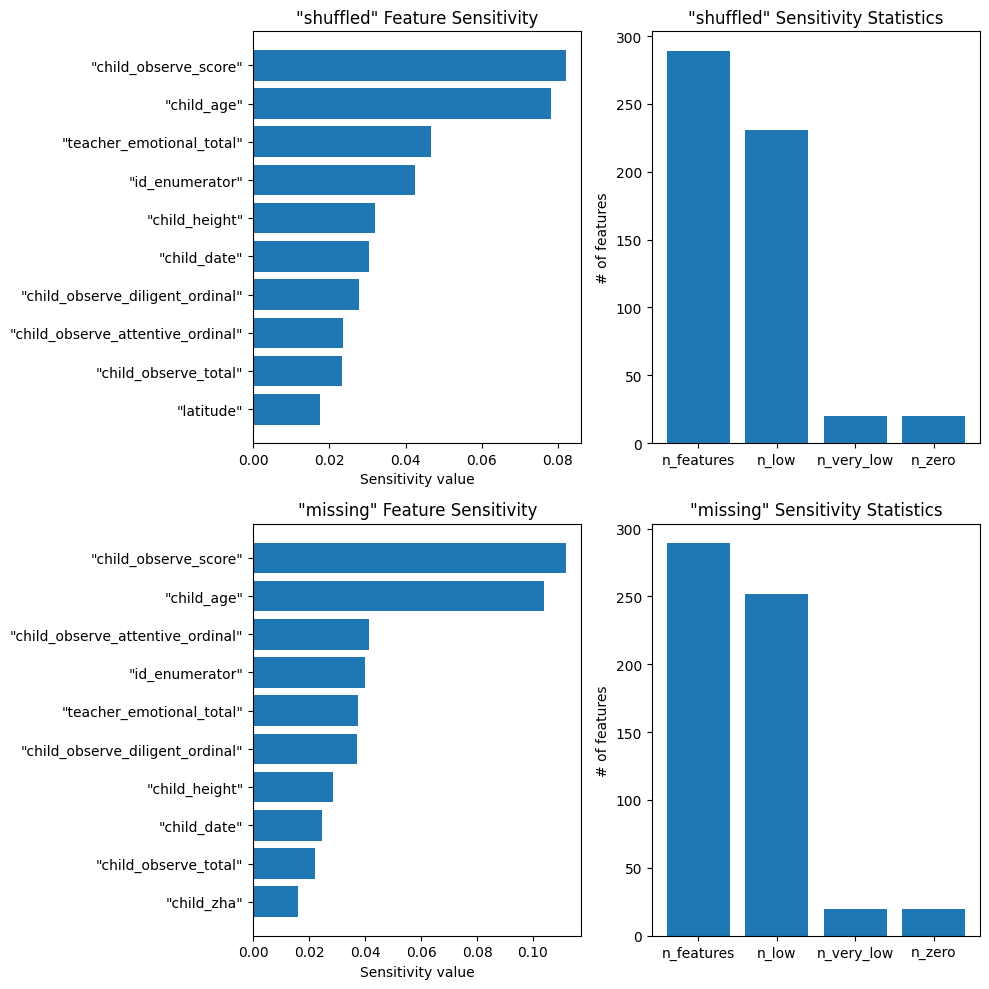

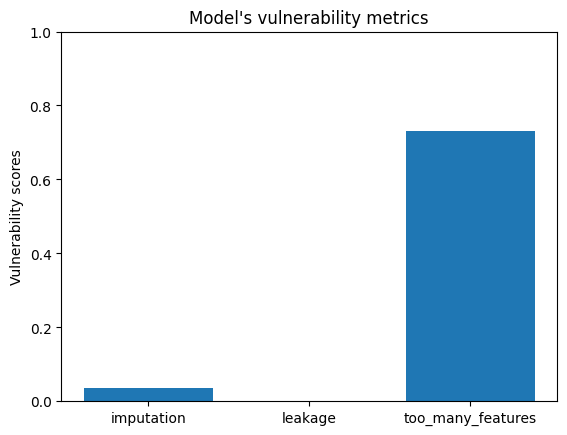

In [11]:
# run analysis and plot graphs
pytrust.sensitivity_report.plot()